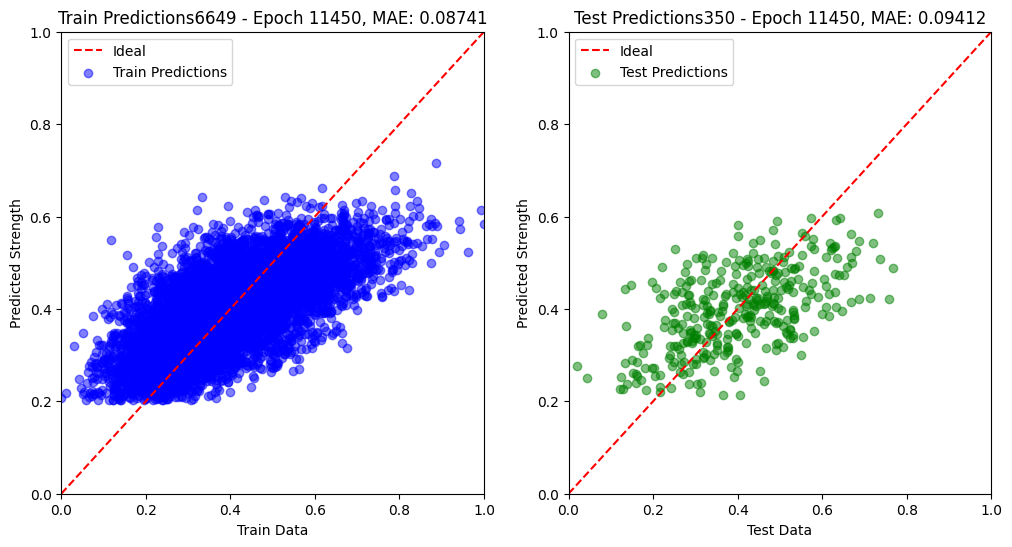

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - Energy_Output_loss: 0.0130 - Energy_Output_mae: 0.0908 - Energy_Output_mse: 0.0130 - Node_Reconstruction_loss: 0.0227 - Node_Reconstruction_mse: 0.0227 - loss: 0.0361 - val_Energy_Output_loss: 0.0132 - val_Energy_Output_mae: 0.0920 - val_Energy_Output_mse: 0.0137 - val_Node_Reconstruction_loss: 0.0226 - val_Node_Reconstruction_mse: 0.0228 - val_loss: 0.0369 - learning_rate: 1.9343e-06
Epoch 11451/20000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Energy_Output_loss: 0.0129 - Energy_Output_mae: 0.0906 - Energy_Output_mse: 0.0129 - Node_Reconstruction_loss: 0.0226 - Node_Reconstruction_mse: 0.0226 - loss: 0.0360 - val_Energy_Output_loss: 0.0132 - val_Energy_Output_mae: 0.0921 - val_Energy_Output_mse: 0.0137 - val_Node_Reconstruction_loss: 0.0226 - val_Node_Reconstruction_mse: 0.0228 - val_loss: 0.0369 - learning_rate: 1.9343e-06
Epoch 11452/20000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Energy_Output_loss: 0.0130 - Energy_Output_mae: 0.0909 - Energy_

In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Flatten, Reshape,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback, EarlyStopping
from IPython.display import display, clear_output
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.regularizers import l2
Iteration=20000
lr=0.001
train_size = 0.95
limit=0.04
l2value=0.005
# Load node data (25 nodes, 3 features: x, y, z)
with open("nodexy.txt", "r") as file:
    NodeOriginal = json.load(file)
NodeOriginal = np.array(NodeOriginal)  # Convert to NumPy array

# Load element data (features for each sample)
with open("thickness.txt", "r") as file:
    element_features = json.load(file)
element_features = np.array(element_features)  # Convert to NumPy array

# Load target values
energy = np.loadtxt("energy_absorbed.txt")
energy = np.array(energy).reshape(-1, 1)  # Ensure correct shape
minValue=np.argmin(energy)
mask=np.arange((len(energy))) !=minValue
NodeOriginal=NodeOriginal[mask,:,:]
element_features=element_features[mask,:]
energy=energy[mask]
# Extract x, y coordinates
NodeOriginal_x = NodeOriginal[:, :, 0]  # Extract all x-coordinates
NodeOriginal_y = NodeOriginal[:, :, 1]  # Extract all y-coordinates

# Identify and remove edge nodes (x or y = 0 or 30)
_, EdgeNodes = np.where((NodeOriginal_x == 0) | (NodeOriginal_x == 30) | (NodeOriginal_y == 0) | (NodeOriginal_y == 30))
EdgeNodes = np.unique(EdgeNodes)  # Get unique node indices to remove

# Create a mask and filter out edge nodes
mask = np.ones(25, dtype=bool)
mask[EdgeNodes] = False
filtered_nodes = NodeOriginal[:, :, :]  # Shape (samples, remaining_nodes, 3)
grid_data_list = []
for sample in filtered_nodes:
    node_positions = sample[:, :2]  # Extract (x, y)
    sorted_indices = np.lexsort((node_positions[:, 0], -node_positions[:, 1]))  # Sort by y (desc), then x (asc)
    sorted_nodes = sample[sorted_indices]  # Reorder nodes spatially
    grid_data = sorted_nodes.reshape(5, 5, 3)  # Convert into 5x5 grid
    grid_data_list.append(grid_data)
# Convert list to NumPy array (samples, 5, 5, 3)
node_grid_data = np.array(grid_data_list)

# Normalize data
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_z = MinMaxScaler()

node_grid_data[:, :, :, 0] = scaler_x.fit_transform(node_grid_data[:, :, :, 0].reshape(-1, 1)).reshape(node_grid_data.shape[:3])
node_grid_data[:, :, :, 1] = scaler_y.fit_transform(node_grid_data[:, :, :, 1].reshape(-1, 1)).reshape(node_grid_data.shape[:3])
node_grid_data[:, :, :, 2] = scaler_z.fit_transform(node_grid_data[:, :, :, 2].reshape(-1, 1)).reshape(node_grid_data.shape[:3])

element_scaler = MinMaxScaler()
element_features = element_scaler.fit_transform(element_features)

energy_scaler = MinMaxScaler()
energy = energy_scaler.fit_transform(energy)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train_nodes, X_test_nodes, X_train_elements, X_test_elements, y_train, y_test = train_test_split(
    node_grid_data, element_features, energy, test_size=1 - train_size, random_state=42)
#node_branch = Flatten()(node_branch)
#node_branch = Dense(32, activation="swish")(node_branch)

# Define CNN model for node features
node_input = Input(shape=(5,5, 3), name="Node_Input")
node_branch = Conv2D(filters=32, kernel_size=(3, 3), activation="swish", padding="same")(node_input)
node_branch = MaxPooling2D(pool_size=(2, 2))(node_branch)
node_branch = Conv2D(filters=32, kernel_size=(3, 3), activation="swish", padding="same",kernel_regularizer=l2(l2value))(node_branch)
node_branch = Conv2D(filters=16, kernel_size=(3, 3), activation="swish", padding="same",kernel_regularizer=l2(l2value))(node_branch)
node_branch = GlobalAveragePooling2D()(node_branch)  # Reduce to 1D
# Define ANN model for element features
element_input = Input(shape=(X_train_elements.shape[1],), name="Element_Input")
element_branch = Dense(32, activation="swish")(element_input)
element_branch = Dropout(0.4)(element_branch)
element_branch = Dense(32, activation="swish",kernel_regularizer=l2(l2value))(element_branch)
element_branch = Dense(16, activation="swish")(element_branch)
element_branch = Dropout(0.2)(element_branch)
# Concatenate CNN and ANN features
merged = Concatenate()([node_branch, element_branch])
latentSpace=Dense(8,activation="swish",kernel_regularizer=l2(l2value),name="Latent")(merged)
merged = Dense(4, activation="swish",kernel_regularizer=l2(l2value))(latentSpace)
merged = Dense(2, activation="swish")(merged)
output = Dense(1, activation="linear", name="Energy_Output")(merged)
decoded = Dense(32, activation="swish",kernel_regularizer=l2(l2value))(latentSpace)
decoded = Dense(64, activation="swish",kernel_regularizer=l2(l2value))(decoded)
decoded = Dense(25*3, activation="swish",kernel_regularizer=l2(l2value))(decoded)
decoded = Reshape((5,5,3))(decoded)
decoded = Conv2DTranspose(8, kernel_size=(3,3), activation="swish", padding="same",kernel_regularizer=l2(l2value))(decoded)
decoded = Conv2DTranspose(3, kernel_size=(3,3), activation="swish", padding="same",kernel_regularizer=l2(l2value))(decoded)
decoded = Reshape((5,5,3), name="Node_Reconstruction")(decoded)

# Create model
#model = Model(inputs=[node_input, element_input], outputs=[output,decoded])
model=load_model("CNN-ANN-2-1.keras")
model.compile(optimizer=Adam(learning_rate=lr), loss={"Energy_Output": "mse", "Node_Reconstruction": "mse"},
              metrics={"Energy_Output": ["mae", "mse"], "Node_Reconstruction": "mse"})

# Define callbacks for early stopping and learning rate reduction
checkpoint = ModelCheckpoint("CNN-ANN-2-1.keras", monitor="val_Energy_Output_mae", save_best_only=True, mode="min", verbose=0)
reduce_lr = ReduceLROnPlateau(monitor="val_Energy_Output_mae", factor=0.8, patience=400, min_lr=1e-6, verbose=0)
class PrintMSECallback(Callback):
        def __init__(self, interval=1000):
            self.interval = interval

        def on_epoch_end(self, epoch, logs=None):
            if (epoch + 1) % self.interval == 0: 
                mae = logs.get("val_Energy_Output_mae")  
                print(f"Epoch {epoch+1}: MAE = {mae:.10f}")
mse_callback = PrintMSECallback(interval=500)

class EarlyStoppingByTrainMAE(Callback):
    def __init__(self, mae_threshold=0.05, verbose=1):
        super().__init__()
        self.mae_threshold = mae_threshold
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs=None):
        """Stop training if train MAE goes below threshold"""
        if logs is None:
            return

        train_mae = logs.get("val_Energy_Output_mae")  # Get training MAE from logs
        if train_mae is not None and train_mae <= self.mae_threshold:
            print(f"\n Stopping training: Train MAE reached {train_mae:.4f}, below threshold {self.mae_threshold} at epoch {epoch+1}. ")
            self.model.stop_training = True
early_stopping = EarlyStoppingByTrainMAE(mae_threshold=limit)  

class LiveScatterCallback(Callback):
    def __init__(self, X_train_nodes,X_test_nodes, X_train_elements,X_test_elements, y_train,y_test, interval=500):
        super().__init__()
        self.X_train_nodes = X_train_nodes
        self.X_train_elements = X_train_elements
        self.y_train = y_train
        self.X_test_nodes = X_test_nodes
        self.X_test_elements = X_test_elements
        self.y_test = y_test
        self.interval = interval  # Update every N epochs
        
        plt.ion()  # Enable interactive mode

        # Set up the figure
        self.fig, self.ax = plt.subplots(1,2,figsize=(12,6))
        self.train_ax = self.ax[0]  # First subplot for training data
        self.test_ax = self.ax[1]   # Second subplot for test data
    

        # Initial scatter plot for train data
        self.train_ax.plot([0, 1], [0, 1], 'r--', label="Ideal")  # y=x reference line
        self.train_scatter = self.train_ax.scatter([], [], alpha=0.5, color="blue", label="Train Predictions")
        self.train_ax.set_xlim(0, 1)
        self.train_ax.set_ylim(0, 1)
        self.train_ax.set_xlabel("Train Data")
        self.train_ax.set_ylabel("Predicted Strength")
        self.train_ax.set_title("Train Predictions vs. True Values")
        self.train_ax.legend()

        # Initial scatter plot for test data
        self.test_ax.plot([0, 1], [0, 1], 'r--', label="Ideal")  # y=x reference line
        self.test_scatter = self.test_ax.scatter([], [], alpha=0.5, color="green", label="Test Predictions")
        self.test_ax.set_xlim(0, 1)
        self.test_ax.set_ylim(0, 1)
        self.test_ax.set_xlabel("Test Data")
        self.test_ax.set_ylabel("Predicted Strength")
        self.test_ax.set_title("Test Predictions vs. True Values")
        self.test_ax.legend()

        plt.show(block=False)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            print(f"Updating scatter plot at epoch {epoch + 1}...")
            #lr = float(self.model.optimizer.lr.numpy())
            #self.learning_rates.append(lr) 

            y_train_pred, _ = self.model.predict([self.X_train_nodes, self.X_train_elements], verbose=0)
            y_test_pred, _ = self.model.predict([self.X_test_nodes, self.X_test_elements], verbose=0)
            

            # Ensure correct shape
            y_train_pred = np.array(y_train_pred).flatten() 
            y_test_pred = np.array(y_test_pred).flatten()
            
            train_mae = mean_absolute_error(self.y_train, y_train_pred)
            test_mae = mean_absolute_error(self.y_test, y_test_pred)

            # Clear previous output in Jupyter Notebook
            clear_output(wait=True)

            # Update train scatter plot
            self.train_ax.clear()
            self.train_ax.plot([0, 1], [0, 1], 'r--', label="Ideal")
            self.train_ax.scatter(self.y_train.flatten(), y_train_pred, alpha=0.5, color="blue", label="Train Predictions")
            self.train_ax.set_xlim(0, 1)
            self.train_ax.set_ylim(0, 1)
            self.train_ax.set_xlabel("Train Data")
            self.train_ax.set_ylabel("Predicted Strength")
            self.train_ax.set_title(f"Train Predictions{len(self.y_train)} - Epoch {epoch+1}, MAE: {train_mae:.5f}")
            self.train_ax.legend()

            # Update test scatter plot
            self.test_ax.clear()
            self.test_ax.plot([0, 1], [0, 1], 'r--', label="Ideal")
            self.test_ax.scatter(self.y_test.flatten(), y_test_pred, alpha=0.5, color="green", label="Test Predictions")
            self.test_ax.set_xlim(0, 1)
            self.test_ax.set_ylim(0, 1)
            self.test_ax.set_xlabel("Test Data")
            self.test_ax.set_ylabel("Predicted Strength")
            self.test_ax.set_title(f"Test Predictions{len(self.y_test)} - Epoch {epoch+1}, MAE: {test_mae:.5f}")
            self.test_ax.legend()

            # Redraw the updated figure
            self.fig.canvas.draw()
            self.fig.canvas.flush_events()
            plt.pause(0.01)  # Ensure real-time updates
            display(self.fig)  # Explicitly display the figure
plot=LiveScatterCallback(X_train_nodes,X_test_nodes, X_train_elements,X_test_elements, y_train, y_test, interval=10)
# Train model
history = model.fit(
    [X_train_nodes, X_train_elements],
    {"Energy_Output": y_train, "Node_Reconstruction": X_train_nodes},
    epochs=Iteration,
    batch_size=256,
    validation_split=0.05,
    callbacks=[checkpoint,plot,reduce_lr],
    verbose=1
)
